## Import necessary packages:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

seed = 0

Probe = ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan']

DoS = ['apache2', 'back', 'land', 'mailbomb', 'neptune', 'pod', 'processtable', 'smurf', 'teardrop', 'udpstorm']

R2L = ['buffer_overflow', 'httptunnel', 'loadmodule', 'perl', 'ps', 'rootkit', 'sqlattack', 'xterm']

U2R = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess',
       'spy', 'warezclient', 'warezmaster', 'worm', 'xlock', 'xsnoop']

## Import data and assign feature name to each column:

In [2]:
columns = []
with open('kddcup.names') as f:
    next(f)
    for line in f:
        feature = line.split(':')[0]
        columns.append(feature)
columns.append('label')

In [4]:
train_data = pd.read_csv('kddcup.data', header=None)
train_data.columns = columns
train_data['label'] = train_data['label'].apply(lambda x: x.replace('.', ''))

test_data = pd.read_csv('corrected', header=None)
test_data.columns = columns
test_data['label'] = test_data['label'].apply(lambda x: x.replace('.', ''))

In [5]:
boundary = train_data.shape[0]
whole_data = pd.concat([train_data, test_data], axis=0)

## One-hot encoding:

In [6]:
categorical = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
whole_data_categorical = whole_data[categorical].copy()
whole_data.drop(columns=categorical, inplace=True)
whole_data_categorical_T = pd.get_dummies(whole_data_categorical)
num_one_hot_features = whole_data_categorical_T.shape[1]
whole_data = pd.concat([whole_data_categorical_T, whole_data], axis=1)

## Split data into training and test set:

In [7]:
train_data = whole_data.iloc[:boundary]
test_data = whole_data.iloc[boundary:]

X_train, y_train = train_data.drop(columns='label'), train_data['label']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=seed)
X_test, y_test = test_data.drop(columns='label'), test_data['label']

## Convert specific attack types to four general attack types in y_valid and y_test:

In [8]:
for attack in Probe:
    y_valid = y_valid.replace(attack, 'Probe')
    y_test = y_test.replace(attack, 'Probe')
    
for attack in DoS:
    y_valid = y_valid.replace(attack, 'DoS')
    y_test = y_test.replace(attack, 'DoS')
    
for attack in R2L:
    y_valid = y_valid.replace(attack, 'R2L')
    y_test = y_test.replace(attack, 'R2L')
    
for attack in U2R:
    y_valid = y_valid.replace(attack, 'U2R')
    y_test = y_test.replace(attack, 'U2R')

## Store preprocessed data for later usage:

In [9]:
X_train.to_pickle("./RF_data/X_train.pkl")
y_train.to_pickle("./RF_data/y_train.pkl")

X_valid.to_pickle("./RF_data/X_valid.pkl")
y_valid.to_pickle("./RF_data/y_valid.pkl")

X_test.to_pickle("./RF_data/X_test.pkl")
y_test.to_pickle("./RF_data/y_test.pkl")

## Load preprocessed data back:

In [2]:
X_train = pd.read_pickle("./RF_data/X_train.pkl")
y_train = pd.read_pickle("./RF_data/y_train.pkl")

X_valid = pd.read_pickle("./RF_data/X_valid.pkl")
y_valid = pd.read_pickle("./RF_data/y_valid.pkl")

X_test = pd.read_pickle("./RF_data/X_test.pkl")
y_test = pd.read_pickle("./RF_data/y_test.pkl")

## Sample a subset of training data from the original training set:

In [3]:
# Recombine X_train and y_train into a dataframe:
X_train_df = pd.concat([X_train, y_train], axis=1)

In [4]:
# Divide instances by label:
label_list = np.unique(X_train_df['label'])

df_label_list = []
for label in label_list:
    df_label_list.append(X_train_df[X_train_df['label'] == label])

In [5]:
# Determine how many instances are sampled from each class:
num_samples_per_label = 300
X_train_df_sampled = pd.DataFrame()

for df in df_label_list:
    num_instances = df.shape[0]
    
    replace = False
    if num_instances < num_samples_per_label:
        replace = True
    
    df_sampled = df.sample(n=num_samples_per_label, replace=replace, random_state=seed)
    X_train_df_sampled = pd.concat([X_train_df_sampled, df_sampled], axis=0)

In [6]:
# Decompose X_train_df_sampled into X_train and y_train again:
X_train, y_train = X_train_df_sampled.drop(columns='label'), X_train_df_sampled['label']

## Convert specific attack types to four general attack types in y_train:

In [7]:
for attack in Probe:
    y_train = y_train.replace(attack, 'Probe')
    
for attack in DoS:
    y_train = y_train.replace(attack, 'DoS')
    
for attack in R2L:
    y_train = y_train.replace(attack, 'R2L')
    
for attack in U2R:
    y_train = y_train.replace(attack, 'U2R')

## Store sampled data

In [8]:
X_train.to_pickle("./RF_data/X_train_sampled.pkl")
y_train.to_pickle("./RF_data/y_train_sampled.pkl")

## Load sampled data

In [2]:
X_train = pd.read_pickle("./RF_data/X_train_sampled.pkl")
y_train = pd.read_pickle("./RF_data/y_train_sampled.pkl")

## Standardize feature vectors using StandardScaler:

In [3]:
sscaler = preprocessing.StandardScaler().fit(X_train)
X_train = sscaler.transform(X_train)

In [26]:
int(np.sqrt(X_train.shape[1]))

11

## Stratified holdout validation:

In [4]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

## Random Forest on all attribtues

In [ ]:
n_estimators = [int(x) for x in np.linspace(20, 2000, num = 100)]
max_depth = [int(x) for x in np.linspace(1, int(np.sqrt(X_train.shape[1])), num = 10)]
max_depth.append(None)


random_grid = {'n_estimators': n_estimators,
               'criterion': ['entropy'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],}

rf = RandomForestClassifier()
rf_grid= GridSearchCV(estimator = rf, 
                      param_grid = random_grid, 
                      cv = sss, 
                      verbose = 2,
                      n_jobs = -1)

rf_grid.fit(X_train, y_train)
#Random Search result 
np.save('./RF_data/RF_best_all.npy',rf_random.best_params_)

Fitting 1 folds for each of 9900 candidates, totalling 9900 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.8s


## Evaluatation

In [29]:
rf_best = rf_random.best_estimator_
y_pred_valid = rf_best.predict_proba(X_valid)

avg_roc_auc = 0
for i, label in enumerate(rf_best.classes_):
    y_valid_label = (y_valid == label).astype(int)
    y_pred_valid_label = y_pred_valid[:,i]
    avg_roc_auc += roc_auc_score(y_valid_label, y_pred_valid_label)
    
avg_roc_auc /= len(rf_best.classes_)

print ("The best average ROC_AUC for Random Forest on validation set is {:.4f}".format(avg_roc_auc))

The best average ROC_AUC for Random Forest on validation set is 0.8381


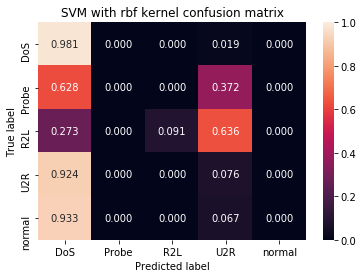

In [30]:
y_pred_valid = rf_best.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred_valid)
cm_normalized = cm / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm_normalized, classes=rf_best.classes_, title='SVM with rbf kernel confusion matrix')

## Split categorical 

In [ ]:
columns = []
with open('kddcup.names') as f:
    next(f)
    for line in f:
        feature = line.split(':')[1]
        columns.append(feature[0:-3])
columns.append('label')

In [22]:
rf_best.score(X_valid, y_valid)

0.07752373972503462

In [27]:
[int(x) for x in np.linspace(1, int(np.sqrt(X_train.shape[1])), num = 10 )]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 11]